# RNetwork Training

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import numpy as np

from tqdm import tqdm
from omegaconf import OmegaConf

import envs
import utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.dataset import RNetPairsSplitDataset
from exploration_buffer import ExplorationBuffer
from rnet.utils import *
from  envs import quadruped_utils as quadruped_utils

from matplotlib import colors
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Config Utils

In [3]:
cfg_path = f"../conf/config.yaml"

env_name = 'quadruped'

cfg = OmegaConf.load(cfg_path)
env_cfg = OmegaConf.load(f'../conf/env/{env_name}.yaml')

cfg = OmegaConf.merge(cfg, env_cfg)

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
device = torch.device("cuda:1")

In [4]:
env = envs.make_env(cfg.env, space_info)

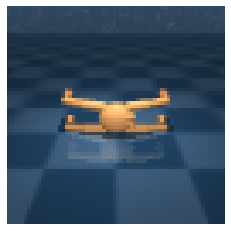

In [5]:
obs = quadruped_utils.get_state_from_lexa(env, env.goals['state'][4])
plt.imshow(env.get_image_from_obs(obs).transpose((1, 2, 0)))
plt.axis('off')
plt.show()

## RNet dataset

In [38]:
cfg.rnet.dataset.thresh = 5
cfg.rnet.dataset.symmetric = False

expl_buffer = ExplorationBuffer(cfg.exploration_buffer)

dataset = RNetPairsSplitDataset(cfg.rnet.dataset, expl_buffer)

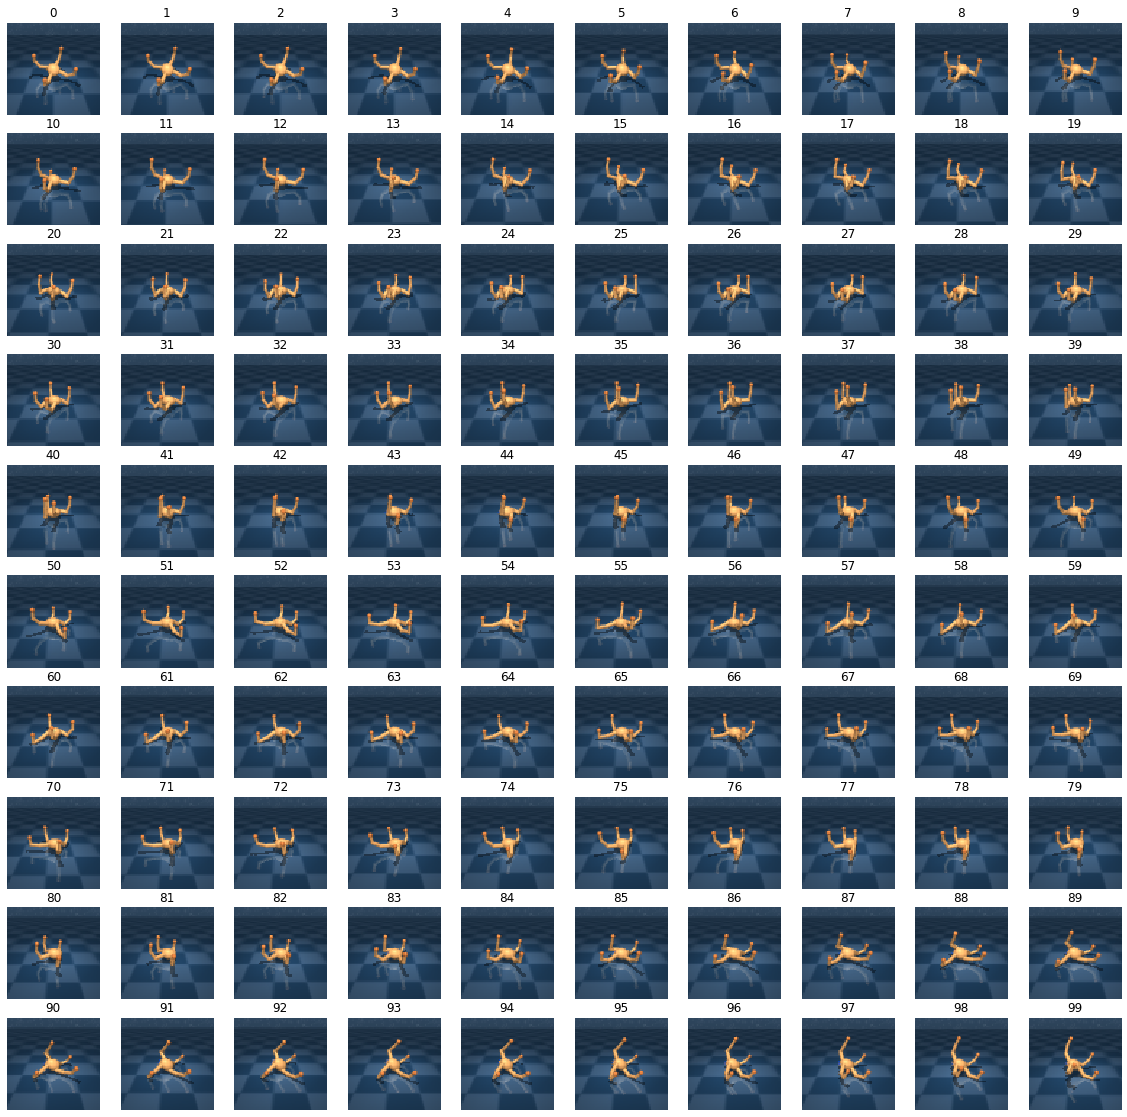

In [39]:
n = 100
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))

traj_idx = np.random.randint(len(expl_buffer))
for i in range(n):
    state = expl_buffer.states[traj_idx][i]
    obs = quadruped_utils.get_state_from_lexa(env, state[:23])
    img = env.get_image_from_obs(obs)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

## Train RNet

In [40]:
model = RNetModel(cfg.rnet.model, space_info)
model = model.to(device)

print(model)

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=44, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [41]:
cfg.rnet.train.num_epochs = 10

stats = train(cfg.rnet.train, model, dataset, device)

rnet epoch 0 - train loss 0.35,  acc 0.86 - val loss 0.16,  acc 0.95
rnet epoch 1 - train loss 0.13,  acc 0.96 - val loss 0.11,  acc 0.96
rnet epoch 2 - train loss 0.10,  acc 0.97 - val loss 0.09,  acc 0.97
rnet epoch 3 - train loss 0.09,  acc 0.97 - val loss 0.08,  acc 0.97
rnet epoch 4 - train loss 0.08,  acc 0.97 - val loss 0.08,  acc 0.97
rnet epoch 5 - train loss 0.08,  acc 0.97 - val loss 0.07,  acc 0.97
rnet epoch 6 - train loss 0.08,  acc 0.97 - val loss 0.07,  acc 0.98
rnet epoch 7 - train loss 0.07,  acc 0.98 - val loss 0.07,  acc 0.98
rnet epoch 8 - train loss 0.07,  acc 0.98 - val loss 0.06,  acc 0.98
rnet epoch 9 - train loss 0.06,  acc 0.98 - val loss 0.05,  acc 0.98


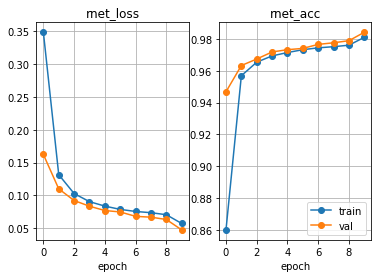

In [42]:
epochs = list(stats.keys())

new_stats = {}
for epoch in epochs:
    for phase in stats[epoch]:
        if not phase in new_stats:
            new_stats[phase] = {}
        for stat, v in stats[epoch][phase].items():
            if not stat in new_stats[phase]:
                new_stats[phase][stat] = []
            if isinstance(v, torch.Tensor):
                v = v.item()
            new_stats[phase][stat].append(v)

fig, ax = plt.subplots(1, 2)
i = 0
for stat in ['rnet_loss', 'rnet_acc']:
    for phase in ['train', 'val']:
        ax[i].plot(epochs, new_stats[phase][stat], label=phase, marker='o')
    ax[i].grid()
    ax[i].set_title(stat)
    ax[i].set_xlabel('epoch')
    i += 1
ax[1].legend()
plt.show()

In [43]:
model.to(device)
model.eval()

model.to(device)
embed_expl_buffer(expl_buffer, model, device)
print(expl_buffer.embs.shape)

expl_buffer.embs = expl_buffer.embs.to(device)

embed exploration buffer: 100%|██████████| 10000/10000 [00:03<00:00, 2619.87it/s]


torch.Size([10000, 1001, 16])


## Build Memory

In [44]:
cfg.rnet.memory.skip = 1
cfg.rnet.memory.skip_traj = 0.01
cfg.rnet.memory.capacity = 1000
cfg.rnet.memory.directed = True

In [45]:
memory = RNetMemory(cfg.rnet.memory, space_info, model.feat_size, device)

model = model.to(device)
memory = build_memory(cfg.rnet.memory, space_info, model, expl_buffer, device)
memory.compute_dist()

Updating Memory: 100%|██████████| 10000/10000 [01:02<00:00, 160.43it/s]


In [46]:
len(memory)

352

out


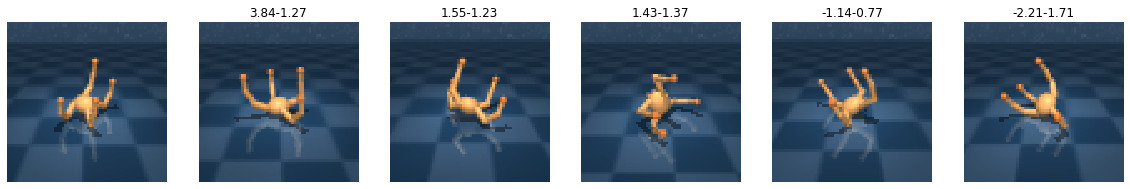

in


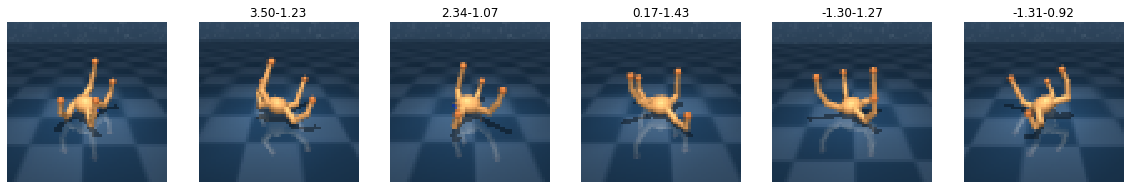

In [53]:
def show_kNN(env, model, memory, obs, state, k=9):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out_o = memory.compare_embeddings(e, model, incoming_dir=False)
    out_i = memory.compare_embeddings(e, model, incoming_dir=True)
    idx_o =  torch.argsort(out_o, descending=True)
    idx_i =  torch.argsort(out_i, descending=True)
    
    print("out")
    _, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = quadruped_utils.get_state_from_lexa(env, state[:23]) 
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx_o[i]]
        obs = quadruped_utils.get_state_from_lexa(env, state_NN[:23]) 
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(
            f"{out_o[idx_o[i]]:.2f}-{env.oracle_distance(state[:23], state_NN[:23]):.2f}"
        )
        ax[i+1].axis('off')
    plt.show()
    
    
    print("in")
    _, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = quadruped_utils.get_state_from_lexa(env, state[:23]) 
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx_i[i]]
        obs = quadruped_utils.get_state_from_lexa(env, state_NN[:23]) 
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(
            f"{out_i[idx_i[i]]:.2f}-{env.oracle_distance(state[:23], state_NN[:23]):.2f}"
        )
        ax[i+1].axis('off')
    plt.show()
    
obs, i, j = expl_buffer.get_random_obs()

#i, j = 6486, 513
#i, j = 7080, 198
#obs = expl_buffer.get_obs(i, j)
state = expl_buffer.states[i, j]
#state = env.goals['state'][i]
#obs = env.goals['vec_obs'][i]
show_kNN(env, model, memory, obs, state, k=5)

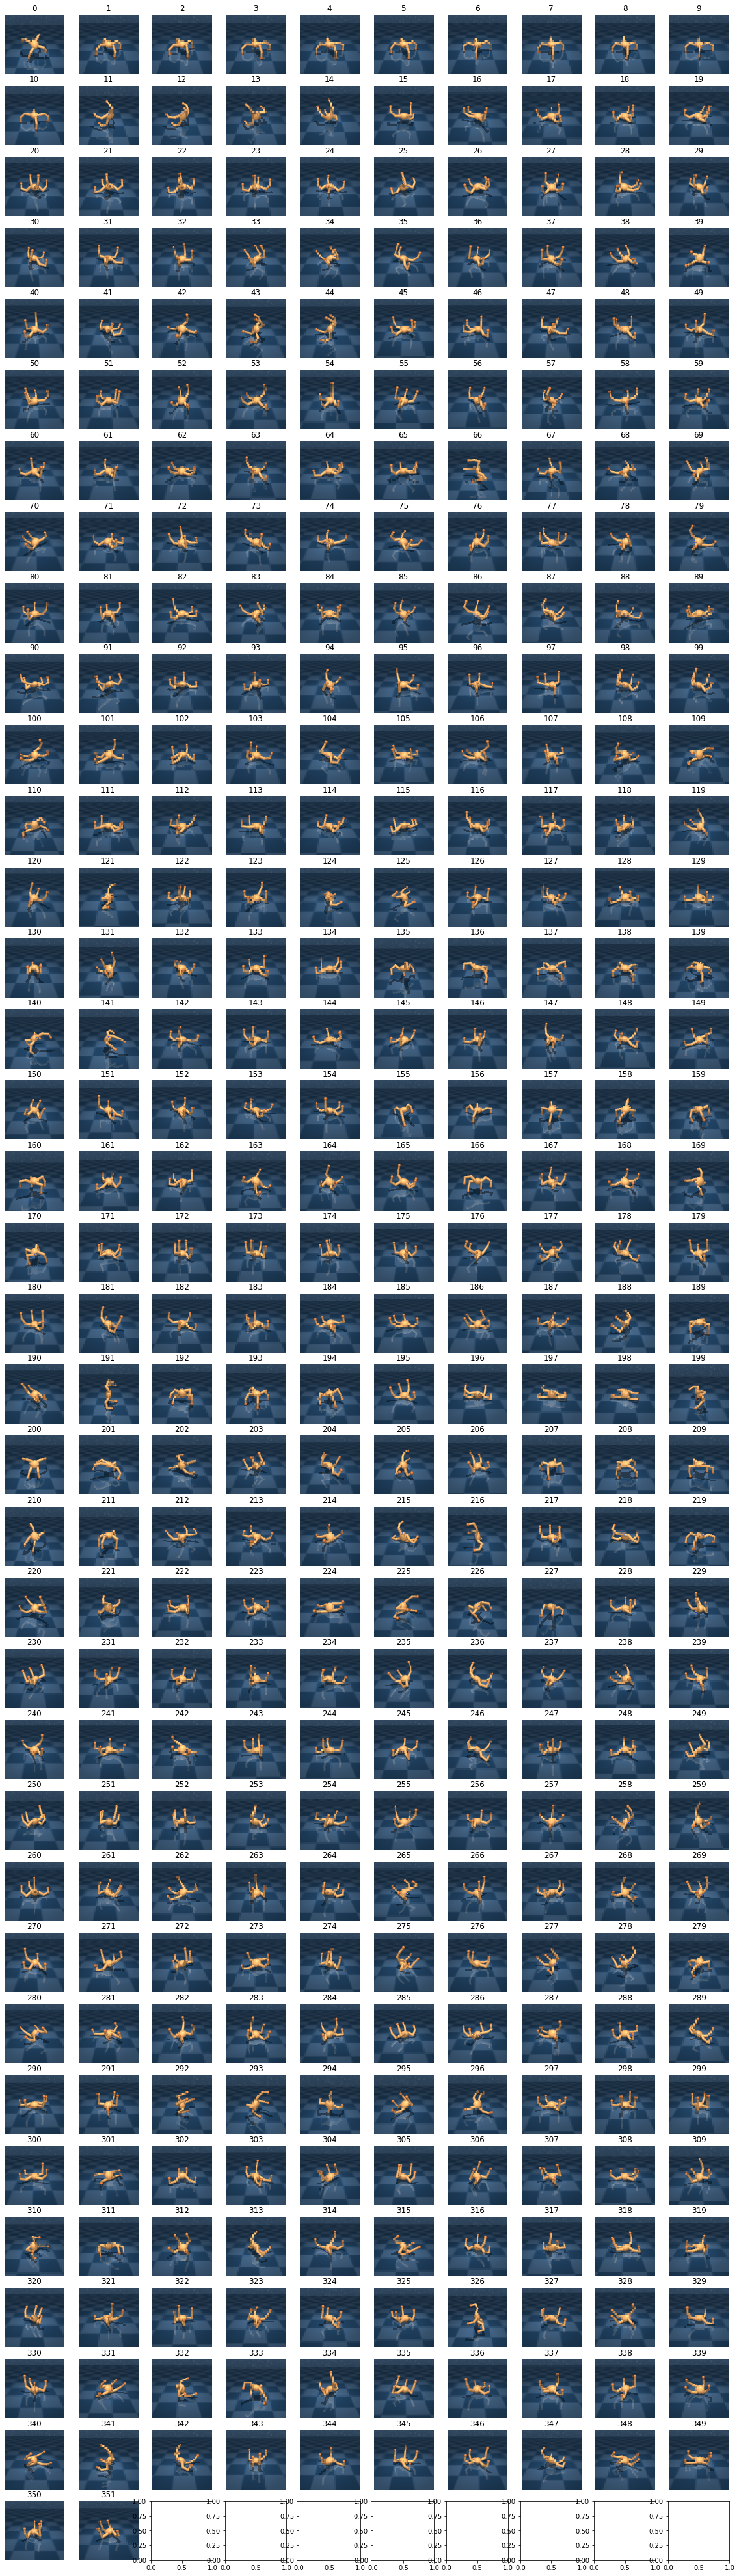

In [48]:
n = len(memory)
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))

for i in range(n):
    state = memory.states[i]
    obs = quadruped_utils.get_state_from_lexa(env, state[:23]) 
    img = env.get_image_from_obs(obs)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

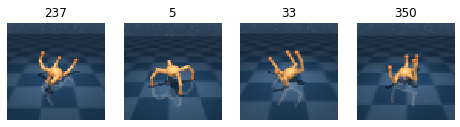

In [51]:
def retrieve_path(pred, i, j):
    if pred[i, j] == -9999:
        return [i]
    path = retrieve_path(pred, i, pred[i, j])
    path.append(j)
    return path

def show_path(env, memory, i, j):
    path = retrieve_path(memory.pred, i, j)
    n = len(path)
    num_cols = n
    num_rows = 1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))
    for p in range(n):
        state = memory.states[path[p]]
        obs = quadruped_utils.get_state_from_lexa(env, state[:23]) 
        img = env.get_image_from_obs(obs)
        ax[p].imshow(img.transpose((1, 2, 0)))
        ax[p].axis('off')
        ax[p].set_title(str(path[p]))
    plt.show()
    
i, j = np.random.randint(len(memory)), np.random.randint(len(memory))
#j=42
show_path(env, memory, i, j)

In [320]:
np.max(memory.dist)

9.0

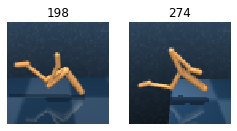

In [257]:
i, j = np.random.randint(len(memory)), np.random.randint(len(memory))
show_path(env, memory, i, j)

tensor(49, device='cuda:1')
tensor(4, device='cuda:1')
tensor(8, device='cuda:1')
tensor(6, device='cuda:1')
tensor(106, device='cuda:1')


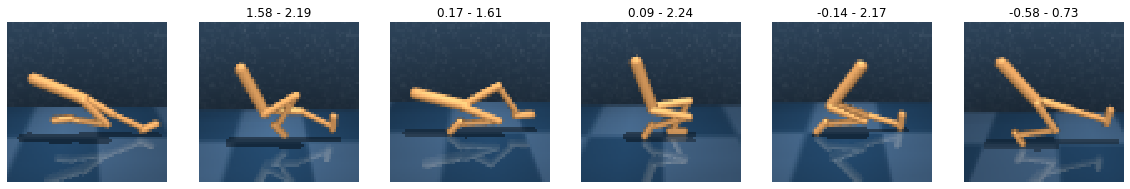

In [215]:
def show_kNN(env, model, memory, obs, state, k=9):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out = memory.compare_embeddings(e, model)
    idx =  torch.argsort(out, descending=True)
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = walker_utils.get_state_from_lexa(env, state[:9]) 
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx[i]]
        print(idx[i])
        obs = walker_utils.get_state_from_lexa(env, state_NN[:9]) 
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out[idx[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()

obs, i, j = expl_buffer.get_random_obs()

#i, j = 6486, 513
#i, j = 7080, 198
#obs = expl_buffer.get_obs(i, j)
state = expl_buffer.states[i, j]
#state = env.goals['state'][i]
#obs = env.goals['vec_obs'][i]
show_kNN(env, model, memory, obs, state, k=5)

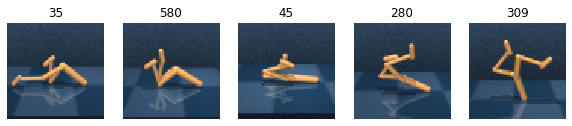

In [362]:
_, i1, j1 = expl_buffer.get_random_obs()
show_path(env, memory, NN[i1, j1], 309)

tensor(42, device='cuda:1')
tensor(43, device='cuda:1')
tensor(221, device='cuda:1')
tensor(214, device='cuda:1')
tensor(315, device='cuda:1')
tensor(48, device='cuda:1')
tensor(41, device='cuda:1')
tensor(173, device='cuda:1')
tensor(326, device='cuda:1')


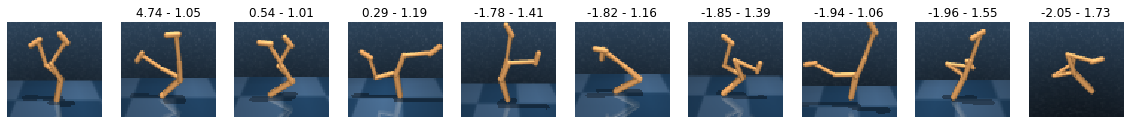

In [216]:
i = np.random.randint(env.num_goals)
i = 10
show_kNN(env, model, memory, env.goals['vec_obs'][i],env.goals['state'][i], k=9)

In [61]:
env.set_goals(memory.get_goals())
fig = env.plot_goals()

AttributeError: 'Environment' object has no attribute 'set_goals'

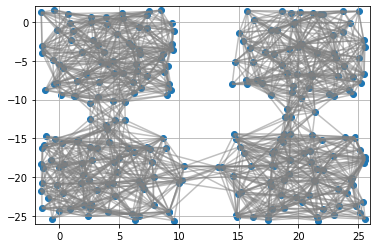

In [13]:
fig = env.plot_graph(memory)

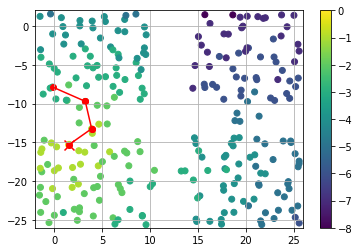

In [14]:
fig = env.plot_graph_dist(memory)

## Compute NN

In [285]:
model.to(device)
NN = compute_NN(expl_buffer, model, memory, device)

computing NN:  53%|█████▎    | 5279/10001 [23:36<21:20,  3.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

computing NN: 100%|██████████| 10001/10001 [44:48<00:00,  3.72it/s]


## Save

In [286]:
exp_name = 'walker_thresh2-velo'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/rnet/', exp_name)

save(save_dir, model, memory, NN)

Saving rnet objects to  /checkpoint/linamezghani/offline-gcrl/rnet/walker_thresh2-velo


In [20]:
avg_distance = 0

for i in tqdm(range(expl_buffer.states.shape[0])):
    for j in range(expl_buffer.states.shape[1]):
        NN_state = memory.states[NN[i, j]]
        avg_distance += np.linalg.norm(NN_state[:2] - expl_buffer.states[i, j, :2])
        
avg_distance /= (expl_buffer.states.shape[0] * expl_buffer.states.shape[1])
print(f"Average distance from state to its NN: {avg_distance:.2f}")

100%|██████████| 10000/10000 [01:06<00:00, 150.26it/s]

Average distance from state to its NN: 1.42


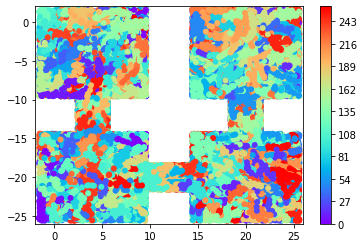

In [27]:
N = 100


traj = expl_buffer.states[:N].reshape((-1, expl_buffer.states.shape[-1]))
flat_NN = NN[:N].flatten()
classes = np.unique(flat_NN)
np.random.shuffle(classes)
c = [np.where(flat_NN[j] == classes)[0][0] for j in range(len(traj))]

cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(0, len(classes), 1), cmap.N)

sc = plt.scatter(traj[:, 0], traj[:, 1], c=c, cmap=cmap, norm=norm, edgecolor='none')
plt.colorbar(sc)
plt.xlim(env.xlim)
plt.ylim(env.ylim)
plt.show()